# Experiments for Data Science master thesis

# Lognormal SABR vs Normal SABR



This short notebook provides an example of how to compare the two main SABR implementations: Hagan's 2002 Shifted Normal and Shifted Lognormal specifications.

Various maturities of swaptions are considered. The results illustrate that the two distributions diverge on the receivers tail, but are fairly consistent around the ATM and on the payers wing.


## Overview

The **SABR model** is a popular stochastic volatility model that describes the evolution of the underlying asset price and its volatility. It is used for pricing **swaptions**, **interest rate derivatives**, and **foreign exchange derivatives**.

- **Normal SABR** (Shifted Normal): This model assumes that the forward price behaves according to a **shifted normal distribution**, making it suitable for modeling instruments where the price remains close to a known value (typically near zero or low volatility).
- **Lognormal SABR** (Shifted Lognormal): In this variant, the underlying asset price follows a **lognormal distribution**, making it appropriate for pricing instruments where prices can vary widely, and the behavior is more aligned with traditional market models.

## Comparison

This notebook compares the two SABR models across various maturities of **swaptions**. The results illustrate key differences in their performance:

- The **two distributions** diverge significantly on the **receiver's tail**, where the lognormal model tends to show more extreme values than the normal model.
- Around the **at-the-money (ATM)** region and on the **payer's wing**, the models tend to give **fairly consistent** results.

### Formula for SABR Model

The SABR model is typically represented by the following stochastic differential equations:

For **Normal SABR**, the process for the forward price $F_t$ is modeled as:

$$
dF_t = \alpha_t F_t^\beta dW_t
$$

where $\alpha_t$ is the volatility, $\beta$ is the volatility of volatility, and $W_t$ is a Wiener process.

For **Lognormal SABR**, the forward price process is modeled with a lognormal distribution:

$$
d\log(F_t) = \alpha_t dW_t
$$

where the parameters are similar, but with an adjustment for the lognormal distribution’s skew and kurtosis.

### Results

By comparing both implementations across different maturities, we can gain insight into how each model performs in pricing swaptions and derivatives, particularly in terms of how they handle extreme movements in the tail of the distribution.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pysabr

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import os.path

# Import both Lognormal and Normal SABR model classes
from pysabr import Hagan2002LognormalSABR
from pysabr import Hagan2002NormalSABR
from pysabr.helpers import year_frac_from_maturity_label


# Load swaption vol surface data


Load swaption vol surface data

In [ ]:
#vols_csv = os.path.join('..', 'pysabr', 'examples', 'vols.csv')
df = pd.read_csv("/content/drive/MyDrive/vols.csv", sep=";")
df.set_index(['Type', 'Option_expiry'], inplace=True)
df.sort_index(inplace=True)
idx = pd.IndexSlice
df.loc[idx[:, '1Y'], '10Y']

Type            Option_expiry
Beta            1Y                0.500000
Forward         1Y                2.536488
Normal_ATM_vol  1Y               59.240000
Rho             1Y               -0.070000
Shift           1Y                2.000000
Volvol          1Y                0.500000
Name: 10Y, dtype: float64


A list of option expiries and swap tenors to display are defined. A granular strike scale of 100 points will be used to compute SABR volatilities.

In [ ]:

option_expiries = ['1M', '1Y', '10Y']
swap_tenors = ['2Y', '10Y', '30Y']
m = len(option_expiries); n = len(swap_tenors)
swaption_grid = list(itertools.product(*[option_expiries, swap_tenors]))
n_strikes = 100
strikes = np.linspace(-1.00, 6.00, n_strikes)


# Display normal vol smiles and densities

For each point of the swaption grid selected at previous step, two SABR models are instantiated using the Hagan2002LognormalSABR and Hagan2002NormalSABR classes.
The model API enables to compute normal vols for both models (independently of the model distribution) in a transparent fashion, using sabr.normal_vol(k) method, for each strike. The resulting smiles (in basis point normal vols) for both models are plotted.

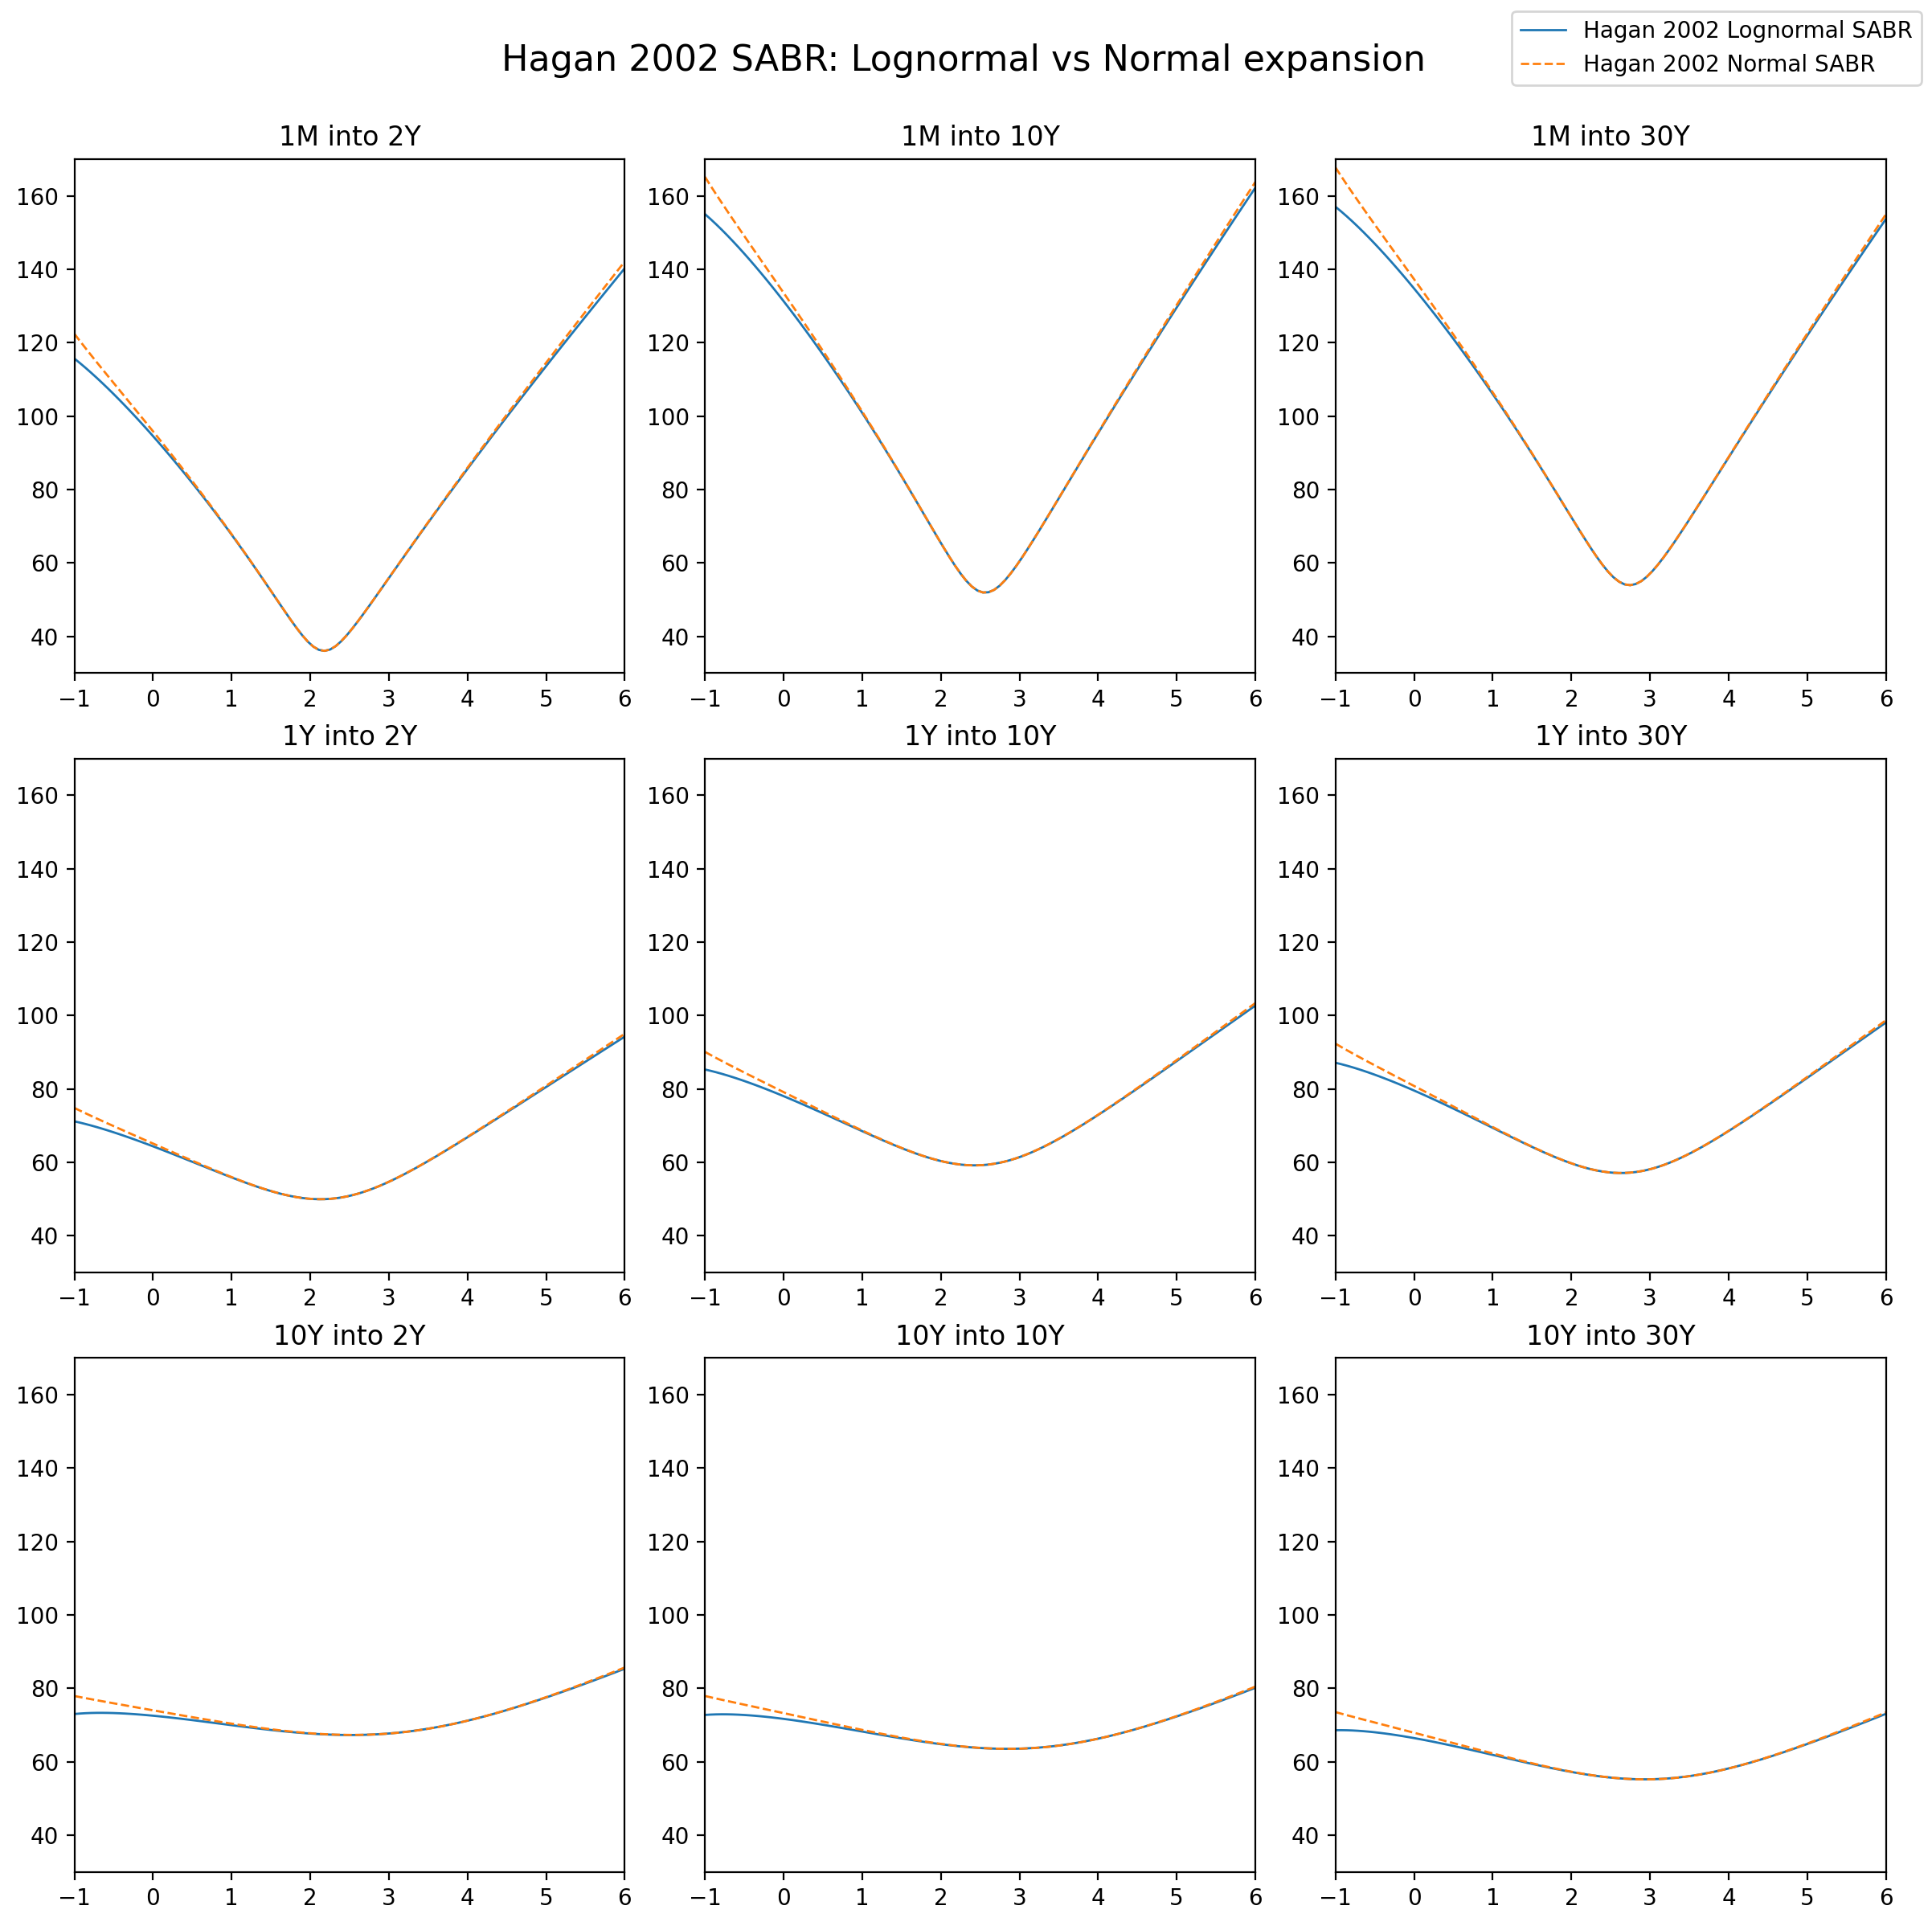

In [ ]:
fig, axes = plt.subplots(m, n)
fig.set_dpi(200)
fig.set_size_inches((12, 12))
fig.tight_layout(w_pad=0.5, h_pad=2.0)

for ((option_expiry, swap_tenor), ax) in zip(swaption_grid, fig.get_axes()):
    beta, f, v_atm_n, rho, shift, volvol = list(df.loc[idx[:, option_expiry], swap_tenor].reset_index(level=1, drop=True))
    t = year_frac_from_maturity_label(option_expiry)
    sabr_ln = Hagan2002LognormalSABR(f/100, shift/100, t, v_atm_n/1e4, beta, rho, volvol)
    sabr_n = Hagan2002NormalSABR(f/100, shift/100, t, v_atm_n/1e4, beta, rho, volvol)
    sabr_ln_vols = [sabr_ln.normal_vol(k/100) * 1e4 for k in strikes]
    sabr_n_vols = [sabr_n.normal_vol(k/100) * 1e4 for k in strikes]
    ax.plot(strikes, sabr_ln_vols, linewidth=1.0, linestyle='-')
    ax.plot(strikes, sabr_n_vols, linewidth=1.0, linestyle='--')
    ax.set_xlim((-1.0, 6.0))
    ax.set_ylim((30., 170.))
    ax.set_title("{} into {}".format(option_expiry, swap_tenor))

line_sabr_ln = axes[0][0].get_lines()[0]
line_sabr_n = axes[0][0].get_lines()[1]
fig.legend(handles=(line_sabr_ln, line_sabr_n), labels=('Hagan 2002 Lognormal SABR', 'Hagan 2002 Normal SABR'), loc='upper right')
fig.suptitle("Hagan 2002 SABR: Lognormal vs Normal expansion", fontsize=16)
fig.subplots_adjust(top=0.92)

# pretty cool results!